In [39]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

# Data Preprocessing


## Load data


In [2]:
train_data = pd.read_csv(
    "./data/train.csv", index_col=False, usecols=lambda x: x != "id"
)
test_data = pd.read_csv("./data/test.csv", index_col=False)

In [3]:
train_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
test_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [6]:
train_data.isnull().sum()  # check for missing values

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [7]:
# Check for duplicates
train_data.duplicated().sum()

0

<Axes: xlabel='CAEC', ylabel='count'>

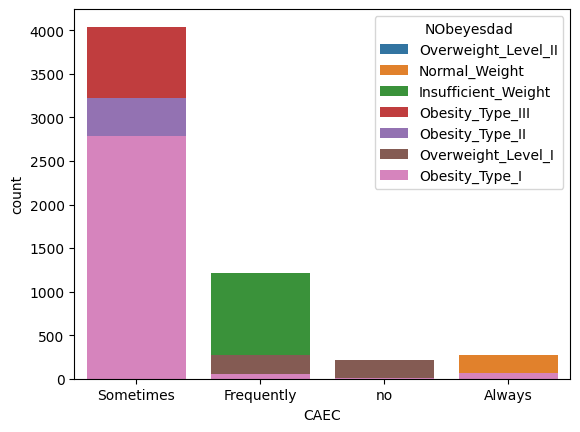

In [8]:
sns.countplot(data=train_data, x="CAEC", hue="NObeyesdad", dodge=False)

<Axes: xlabel='CALC', ylabel='count'>

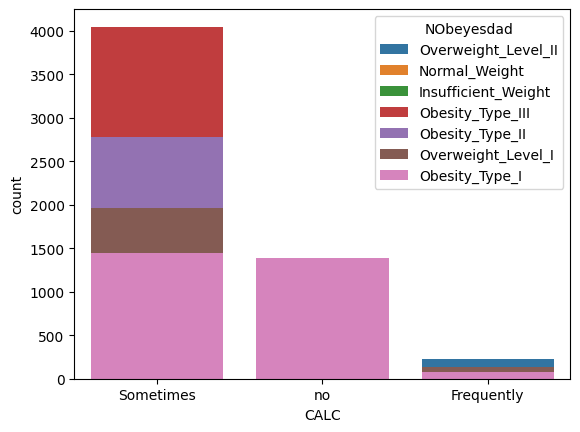

In [9]:
sns.countplot(data=train_data, x="CALC", hue="NObeyesdad", dodge=False)

In [10]:
test_data.CALC.unique()

array(['Sometimes', 'no', 'Frequently', 'Always'], dtype=object)

<Axes: xlabel='SCC', ylabel='count'>

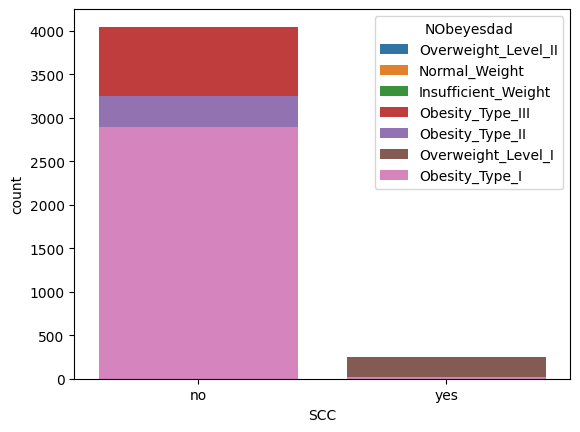

In [11]:
sns.countplot(data=train_data, x="SCC", hue="NObeyesdad", dodge=False)

We don't have any missing value in this dataset


In [12]:
train_data["NObeyesdad"].value_counts()

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

A bit imbalanced target in raw dataset. So we will use upsampling technique to balance our dataset

In [13]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = train_data[train_data["NObeyesdad"] == "Obesity_Type_III"]
minority_class = train_data[train_data["NObeyesdad"] != "Obesity_Type_III"]

# Upsample minority class
minority_upsampled = resample(
    minority_class,
    replace=True,
    n_samples=len(majority_class),  # match number of samples in majority class
    random_state=42,  # reproducible results
)

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([majority_class, minority_class, minority_upsampled])

# Shuffle the upsampled dataset
upsampled_data = upsampled_data.sample(frac=1, random_state=42)

# Check the class distribution
upsampled_data["NObeyesdad"].value_counts()


NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        4009
Normal_Weight          3835
Obesity_Type_I         3629
Overweight_Level_II    3118
Insufficient_Weight    3111
Overweight_Level_I     3056
Name: count, dtype: int64

In [14]:
features = upsampled_data.drop("NObeyesdad", axis=1)
target = upsampled_data["NObeyesdad"]

In [15]:
features.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
1371,Male,30.605225,1.752456,119.081804,yes,yes,2.499626,3.000000,Sometimes,no,1.784710,no,0.647632,0.173232,Sometimes,Automobile
811,Male,18.106820,1.751038,103.743534,yes,yes,2.910733,2.122545,Sometimes,no,2.702789,no,1.910432,1.000000,no,Public_Transportation
4067,Female,19.000000,1.650000,49.000000,yes,yes,3.000000,3.000000,Sometimes,no,2.000000,no,2.000000,1.000000,no,Public_Transportation
11633,Male,19.462713,1.812259,87.070234,yes,yes,2.443538,2.696051,Sometimes,no,2.876096,no,0.939671,1.000000,Sometimes,Public_Transportation
9521,Male,39.129291,1.785241,108.897324,yes,yes,2.000000,3.000000,Sometimes,no,2.000000,no,1.000000,0.000000,Sometimes,Automobile


In [16]:
target.head()

1371         Obesity_Type_II
811           Obesity_Type_I
4067     Insufficient_Weight
11633    Overweight_Level_II
9521          Obesity_Type_I
Name: NObeyesdad, dtype: object

## Data encoder


### Find continuous and categorical features


In [17]:
continuous_features = features.select_dtypes(include=[np.number]).columns
continuous_features

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

In [18]:
features[continuous_features].describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,24804.000000,24804.000000,24804.000000,24804.000000,24804.000000,24804.000000,24804.000000,24804.000000
mean,23.807662,1.700837,86.678176,2.427713,2.750144,2.019564,0.996193,0.619129
std,5.744912,0.088292,26.055260,0.531099,0.718752,0.607457,0.836409,0.609559
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.895877,1.631807,65.000000,2.000000,3.000000,1.791286,0.023574,0.000000
50%,22.676243,1.700000,83.000000,2.262292,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.764138,110.792630,3.000000,3.000000,2.495961,1.609938,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [19]:
category_features = features.select_dtypes(include=[np.object_]).columns
features[category_features].describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
count,24804,24804,24804,24804,24804,24804,24804,24804
unique,2,2,2,4,2,2,3,5
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
freq,12787,20118,22589,20789,24517,23927,17756,19809


In [20]:
ordinal_cols = ["CAEC", "CALC"]
binary_cols = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
ohe_cols = ["MTRANS"]

### Create pipeline for data transformers


In [21]:
continuous_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", continuous_transformer, continuous_features),
        ("ohe", OneHotEncoder(handle_unknown="ignore"), ohe_cols),
        ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols),
        ("bin", OrdinalEncoder(), binary_cols),
    ], remainder="passthrough"
)

In [22]:
label_encoder = LabelEncoder()

### Split data


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target,
    shuffle=True,
)

In [24]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [25]:
# Get the feature names for one-hot encoded columns
ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(ohe_cols)

# Combine all feature names
all_feature_names = np.concatenate(
    [continuous_features, ohe_feature_names, ordinal_cols, binary_cols]
    # If you have remainder columns that were passed through, add their names here too
)

# Convert the processed array back to a dataframe
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)

# Verify the transformed dataframe
X_train_processed_df.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,CAEC,CALC,Gender,family_history_with_overweight,FAVC,SMOKE,SCC
0,-0.314611,-0.005969,-1.407423,1.077746,0.347395,-0.027371,1.195472,0.623907,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.489109,-0.457707,-1.100253,1.077746,0.347395,-1.670696,1.195472,0.623907,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.489109,-0.005969,-0.793082,1.077746,0.347395,-0.027371,-1.193579,2.263460,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0
3,-1.012602,-0.005969,-1.407423,-2.689020,1.739417,-1.670696,1.195472,0.623907,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-1.187100,1.123376,0.320409,1.077746,0.347395,1.615955,2.389997,0.623907,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0


# Modeling


## Evaluation function


In [26]:
def evaluate_model(model_pipeline, X_val, Y_val):
    predictions = model_pipeline.predict(X_val)

    report = classification_report(Y_val, predictions, output_dict=True)
    f1_macro = report["macro avg"]["f1-score"]
    precision_macro = report["macro avg"]["precision"]
    recall_macro = report["macro avg"]["recall"]

    metrics_df = pd.DataFrame(
        {
            "F1-Score (Macro)": [f1_macro],
            "Precision (Macro)": [precision_macro],
            "Recall (Macro)": [recall_macro],
        }
    )

    return metrics_df

## Create ML model


In [27]:
lr_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "model",
            LogisticRegressionCV(multi_class="multinomial"),
        ),
    ]
)

In [28]:
rf_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "model",
            RandomForestClassifier(
                n_estimators=150, random_state=42, criterion="entropy"
            ),
        ),
    ]
)

In [29]:
svc_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", SVC(max_iter=1000)),
    ]
)

In [30]:
dt_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", DecisionTreeClassifier(max_depth=10)),
    ]
)

In [31]:
gb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "model",
            GradientBoostingClassifier(
                max_depth=10,
                n_estimators=200,
                learning_rate=0.05,
                random_state=42,
                subsample=0.8,
            ),
        ),
    ]
)

In [40]:
xgb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "model",
            XGBClassifier(
                max_depth=10,
                n_estimators=200,
                learning_rate=0.05,
                random_state=42,
                subsample=0.8,
            ),
        ),
    ]
)

### Training


In [50]:
lr_pipeline.fit(X_train, y_train_encoded)

/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MTRANS']),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['CAEC', 'CALC']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC'])])),
                ('model', LogisticRegressionCV(multi_class='multinomial'))])

In [51]:
rf_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MTRANS']),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['CAEC', 'CALC']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC'])])),
                ('model',
                 RandomForestClassifier(criterion='entropy', n_estimators=150,
                                        random_state=42))])

In [52]:
svc_pipeline.fit(X_train, y_train_encoded)

/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MTRANS']),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['CAEC', 'CALC']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC'])])),
                ('model', SVC(max_iter=1000))])

In [53]:
dt_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MTRANS']),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['CAEC', 'CALC']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC'])])),
                ('model', DecisionTreeClassifier(max_depth=10))])

In [54]:
gb_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MTRANS']),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['CAEC', 'CALC']),
                                                 ('bin', OrdinalEncoder(),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=10,
                                            n_estimators=200, random_state=42,
                                            subsample=0.8))])

In [55]:
xgb_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MTRANS']),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### Model Evaluation


In [56]:
evaluate_model(xgb_pipeline, X_test, y_test_encoded)

,F1-Score (Macro),Precision (Macro),Recall (Macro)
0,0.928729,0.928845,0.928739


In [57]:
results = []

for name, pipeline in [
    ("Logistic Regression", lr_pipeline),
    ("Random Forest Classifier", rf_pipeline),
    ("SVC", svc_pipeline),
    ("Decision Tree Classifier", dt_pipeline),
    ("Gradient Boosting Classifier", gb_pipeline),
    ("XGBoost Classifier", xgb_pipeline),
]:
    result = evaluate_model(pipeline, X_test, y_test_encoded)
    result.index = [name]
    results.append(result)

results_df = pd.concat(results)
results_df

,F1-Score (Macro),Precision (Macro),Recall (Macro)
Logistic Regression,0.851893,0.851503,0.853650
Random Forest Classifier,0.926177,0.926853,0.925665
SVC,0.875626,0.876694,0.876679
Decision Tree Classifier,0.887130,0.886714,0.887771
Gradient Boosting Classifier,0.933320,0.933394,0.933306
XGBoost Classifier,0.928729,0.928845,0.928739


## Prediction


In [60]:
predictions = xgb_pipeline.predict(test_data)
decoded_predictions = label_encoder.inverse_transform(predictions)

# Create a DataFrame with Id and NObeyesdad columns
predictions_df = pd.DataFrame(
    {"id": test_data["id"], "NObeyesdad": decoded_predictions}
)

# Save the predictions to a CSV file
predictions_df.to_csv("submission.csv", index=False)